## Hypothesis II - Proposed Modeling Arpproach III

##### Input: Parametric UMAP Dimensions

##### Downstream Model: LASSO

##### Validation: 5-fold CV


In [1]:
import operator
import os
import datetime
import gc
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import tensorflow as tf
from tensorflow.keras import layers

import umap
from umap import UMAP
from umap.parametric_umap import ParametricUMAP

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso, LassoCV

import shap
import cv2

c:\Users\Fared.Farag\AppData\Local\pypoetry\Cache\virtualenvs\umap-Kp0glNbV-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Yield Data


In [3]:
df_2022 = pd.read_csv("../../../../Datasets/Agronomic/2022/Dataset_2022.csv")
df_2022 = df_2022.sort_values(by="Plot_Number")

# remove missing yield
df_2022 = df_2022[df_2022["Yield"].notna()].reset_index(drop=True)

# get plot Numbers
df_2022["Plot_Number"] = df_2022["Plot_Number"].astype(str)
plotNumbers_2022 = list(df_2022["Plot_Number"].unique())

# keep only necessary attributes
df_2022 = df_2022.iloc[:, [0, 1, 2, 5, 6, 7, 10]]
df_2022

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield,Heading_100
0,31760,RT7521FP,Hybrid_RT7521FP,130,1,13.701755,86
1,31761,RT7521FP,Hybrid_RT7521FP,130,1,13.701755,85
2,31762,RT7521FP,Hybrid_RT7521FP,130,1,14.915789,85
3,31763,RT7521FP,Hybrid_RT7521FP,130,1,12.834534,82
4,31764,RT7521FP,Hybrid_RT7521FP,130,1,13.354943,86
...,...,...,...,...,...,...,...
147,31935,IAC600,Tiara,200,2,4.112456,74
148,31936,Tiara,Tiara,200,3,4.482405,82
149,31937,IAC600,Tiara,200,3,3.667944,74
150,31938,Sierra,Tiara,200,3,6.088385,91


**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [3]:
seedCounter = 100
trainPlots = []
testPlots = []

for e in df_2022["Experiment_Name"].unique():
    for c in df_2022[df_2022["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in df_2022[
            (df_2022["Experiment_Name"] == e) & (df_2022["Rice_Cultivar"] == c)
        ]["Nitrogen_Rate"].unique():
            replicates = df_2022[
                (df_2022["Experiment_Name"] == e)
                & (df_2022["Rice_Cultivar"] == c)
                & (df_2022["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = df_2022[
                (df_2022["Experiment_Name"] == e)
                & (df_2022["Rice_Cultivar"] == c)
                & (df_2022["Nitrogen_Rate"] == n)
                & (df_2022["Replicate"] != picked)
            ]["Plot_Number"].values

            test = df_2022[
                (df_2022["Experiment_Name"] == e)
                & (df_2022["Rice_Cultivar"] == c)
                & (df_2022["Nitrogen_Rate"] == n)
                & (df_2022["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter, train, test

Experiment: Hybrid_RT7521FP, Cultivar: RT7521FP, Nitrogen: 130 
Train plots: ['31770' '31771' '31772' '31773' '31774' '31775' '31776' '31777' '31778'
 '31779' '31780' '31781' '31782' '31783' '31784' '31785' '31786' '31787'
 '31788' '31789']
Test plots: ['31760' '31761' '31762' '31763' '31764' '31765' '31766' '31767' '31768'
 '31769']
---------------------------------------------------------------
Experiment: Inbred_Jeff + NIL, Cultivar: NIL 43, Nitrogen: 130 
Train plots: ['31790' '31793' '31795' '31797' '31799' '31810' '31812' '31816' '31818'
 '31819']
Test plots: ['31802' '31805' '31807' '31808' '31809']
---------------------------------------------------------------
Experiment: Inbred_Jeff + NIL, Cultivar: Jefferson, Nitrogen: 130 
Train plots: ['31800' '31801' '31803' '31804' '31806' '31811' '31813' '31814' '31815'
 '31817']
Test plots: ['31791' '31792' '31794' '31796' '31798']
---------------------------------------------------------------
Experiment: Mini_Core, Cultivar: EMBRAPA 

In [4]:
dfTrain = df_2022[df_2022["Plot_Number"].isin(trainPlots)].reset_index(drop=True)
dfTrain

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield,Heading_100
0,31770,RT7521FP,Hybrid_RT7521FP,130,2,13.875162,86
1,31771,RT7521FP,Hybrid_RT7521FP,130,2,13.354943,85
2,31772,RT7521FP,Hybrid_RT7521FP,130,2,13.701755,86
3,31773,RT7521FP,Hybrid_RT7521FP,130,2,14.222165,86
4,31774,RT7521FP,Hybrid_RT7521FP,130,2,14.222165,86
...,...,...,...,...,...,...,...
98,31931,Tiara,Tiara,200,1,6.033897,82
99,31932,Scarlett,Tiara,200,2,10.484756,91
100,31933,Tiara,Tiara,200,2,5.695494,82
101,31934,Sierra,Tiara,200,2,6.441127,92


#### Load Transformed Data


In [5]:
LATE_BOOT_DATES = ["06-09-2022", "06-17-2022", "06-25-2022", "07-19-2022"]
embedding = joblib.load("Saved_Models/Transformed_Data/Train")

dateDf = pd.concat([dfTrain] * len(LATE_BOOT_DATES)).reset_index(drop=True)
dateDf["Date"] = np.nan

start = 0
end = 1
for date in LATE_BOOT_DATES:
    dateDf.iloc[len(dfTrain) * start : len(dfTrain) * end, -1] = date
    start += 1
    end += 1

dfEmbeddingTrain = pd.concat(
    [dateDf.reset_index(drop=True), pd.DataFrame(embedding)], axis=1
)

# rename components
for i in range(len(dateDf.columns), len(dfEmbeddingTrain.columns), 1):
    dfEmbeddingTrain.rename(
        columns={
            dfEmbeddingTrain.columns[i]: "UMAP_" + str(i - len(dateDf.columns) + 1)
        },
        inplace=True,
    )

del start, end, date, dateDf, i

#### Visualize PUMAP Dimensions


In [6]:
# insert emergence dates
tmp = dfEmbeddingTrain.copy()
tmp["Emergence_DOY"] = 140
tmp.loc[tmp["Experiment_Name"] == "Mini_Core", "Emergence_DOY"] = 139

# add 100% heading dates
tmp["Heading_100_DOY"] = tmp["Emergence_DOY"] + tmp["Heading_100"]

# calculate days to 100% heading
tmp["Days_to_100%_Heading"] = tmp.apply(
    lambda x: datetime.datetime.strptime(x["Date"], "%m-%d-%Y").timetuple().tm_yday
    - x["Heading_100_DOY"],
    axis=1,
)

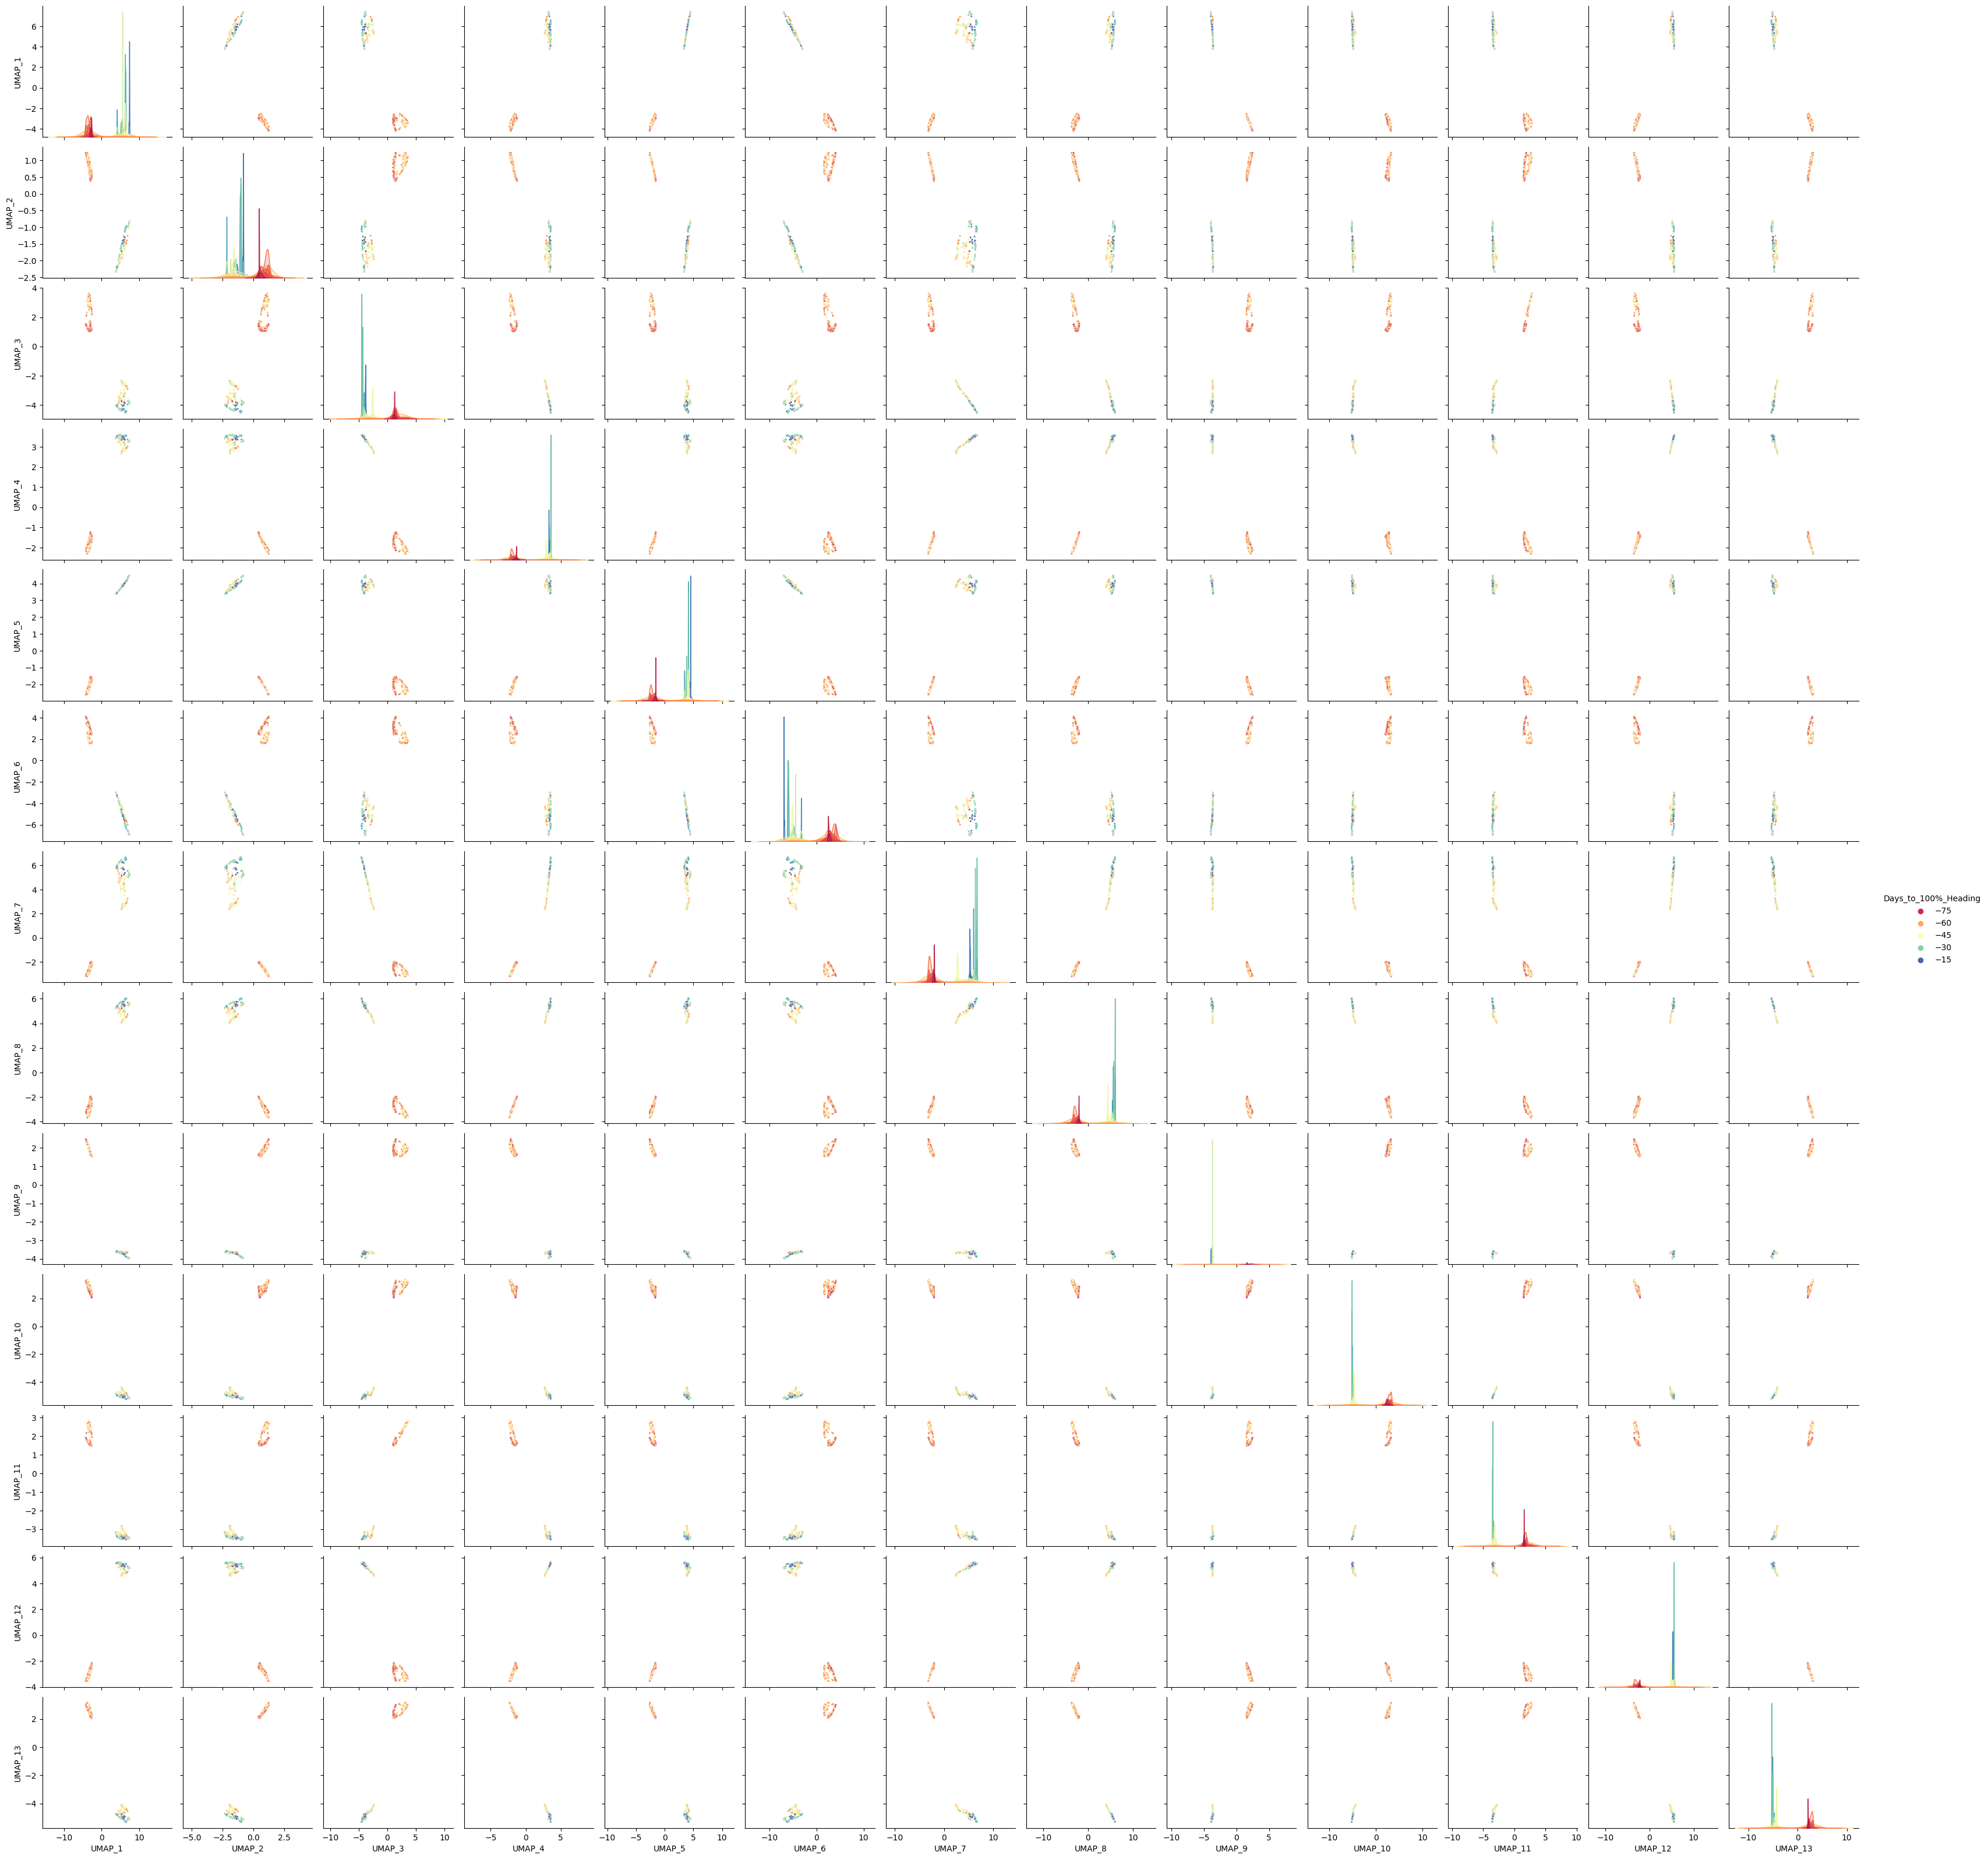

In [8]:
sns.pairplot(
    tmp.loc[
        :,
        ["Days_to_100%_Heading"]
        + list(
            tmp.columns[
                tmp.columns.get_loc("UMAP_1") : tmp.columns.get_loc("UMAP_13") + 1
            ]
        ),
    ],
    hue="Days_to_100%_Heading",
    palette="Spectral",
    plot_kws={"s": 5},
)

#### Preprocess UMAP dimensions


In [10]:
# wide to long then long to wide
dfLongTrain = pd.melt(
    dfEmbeddingTrain,
    id_vars=dfEmbeddingTrain.iloc[:, :8],
    value_vars=dfEmbeddingTrain.iloc[:, 8:],
)

dfWideTrain = pd.pivot(
    dfLongTrain,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTrain.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTrain.columns.tolist()
]

del dfLongTrain

#### Training


In [11]:
def lassoCV_custom(xTrain, yTrain, nfolds, alpha=1):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=100)

    cvResults = []
    for trainIndices, valIndices in kfold.split(xTrain):
        xTrainCV, xValCV = xTrain[trainIndices], xTrain[valIndices]
        yTrainCV, yValCV = yTrain[trainIndices], yTrain[valIndices]

        # fit model
        lassoModel = Lasso(max_iter=10000, alpha=alpha)
        lassoModel.fit(xTrainCV, yTrainCV)
        preds = lassoModel.predict(xValCV)
        cvResults.append(mean_squared_error(yValCV, preds, squared=False))

    return cvResults

In [15]:
xTrain = dfWideTrain.iloc[:, 6:].values
yTrain = dfWideTrain["Yield"]
N_FOLDS = 5

defaultModel = Lasso(max_iter=10000).fit(xTrain, yTrain)

print(f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS))}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, defaultModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 3.513757234928775
Training RMSE: 3.3020210833171704


#### Tuning Lambda


In [16]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=100)
tunedModel = LassoCV(max_iter=100000, cv=cv, n_jobs=-1).fit(xTrain, yTrain)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.567216396331787, tolerance: 0.14018189907073975
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9486910104751587, tolerance: 0.12693916261196136
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0859081745147705, tolerance: 0.12693916261196136


#### Visualize CV


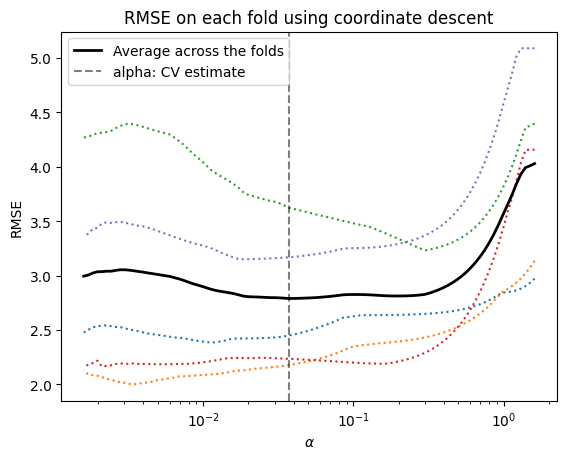

In [17]:
plt.semilogx(tunedModel.alphas_, tunedModel.mse_path_**0.5, linestyle=":")
plt.plot(
    tunedModel.alphas_,
    tunedModel.mse_path_.mean(axis=-1) ** 0.5,
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    tunedModel.alpha_,
    linestyle="--",
    color="black",
    label="alpha: CV estimate",
    alpha=0.5,
)

plt.xlabel(r"$\alpha$")
plt.ylabel("RMSE")
plt.legend()
_ = plt.title(f"RMSE on each fold using coordinate descent")

In [18]:
print(
    f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS, tunedModel.alpha_))}"
)
print(
    f"Training RMSE: {mean_squared_error(yTrain, tunedModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 2.733913921198364
Training RMSE: 2.437583475028663


#### Interpret Model


In [19]:
explainer = shap.Explainer(lambda x: tunedModel.predict(x), xTrain)
shapValues = explainer.shap_values(xTrain)

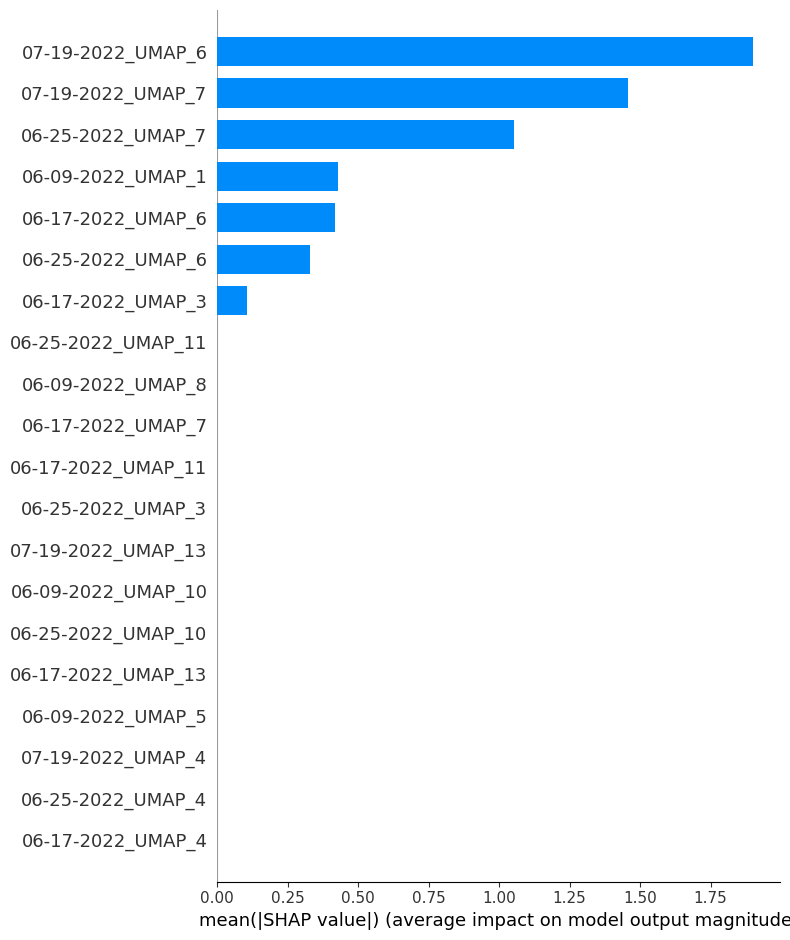

In [20]:
shap.summary_plot(shapValues, plot_type="bar", feature_names=dfWideTrain.columns[6:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


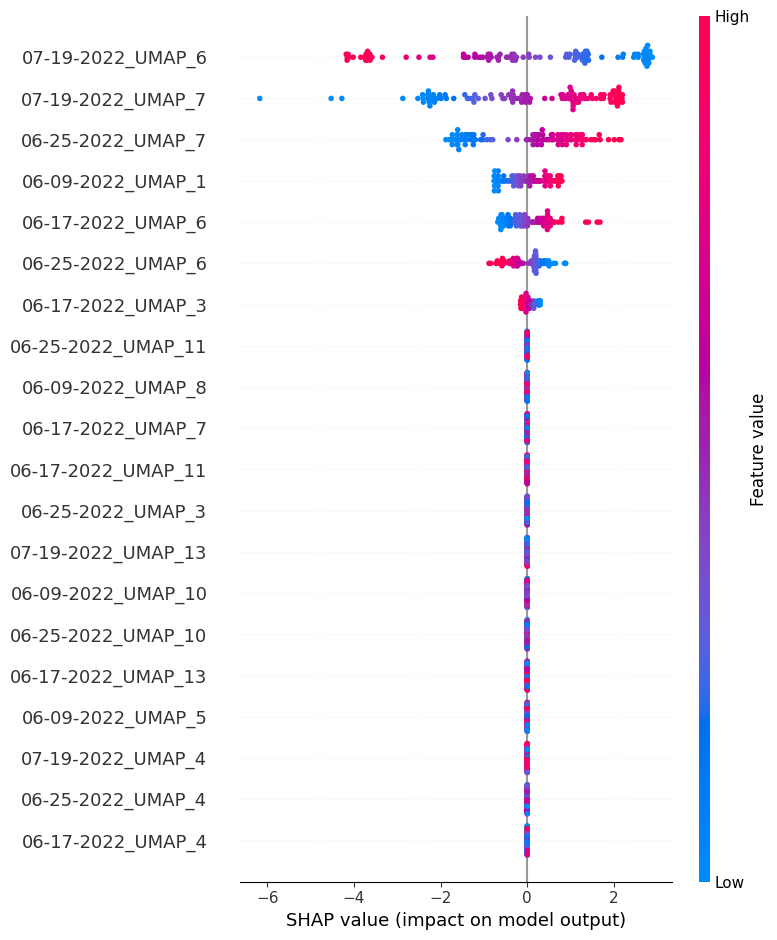

In [21]:
shap.summary_plot(
    shapValues, plot_type="dot", feature_names=dfWideTrain.columns[6:], features=xTrain
)

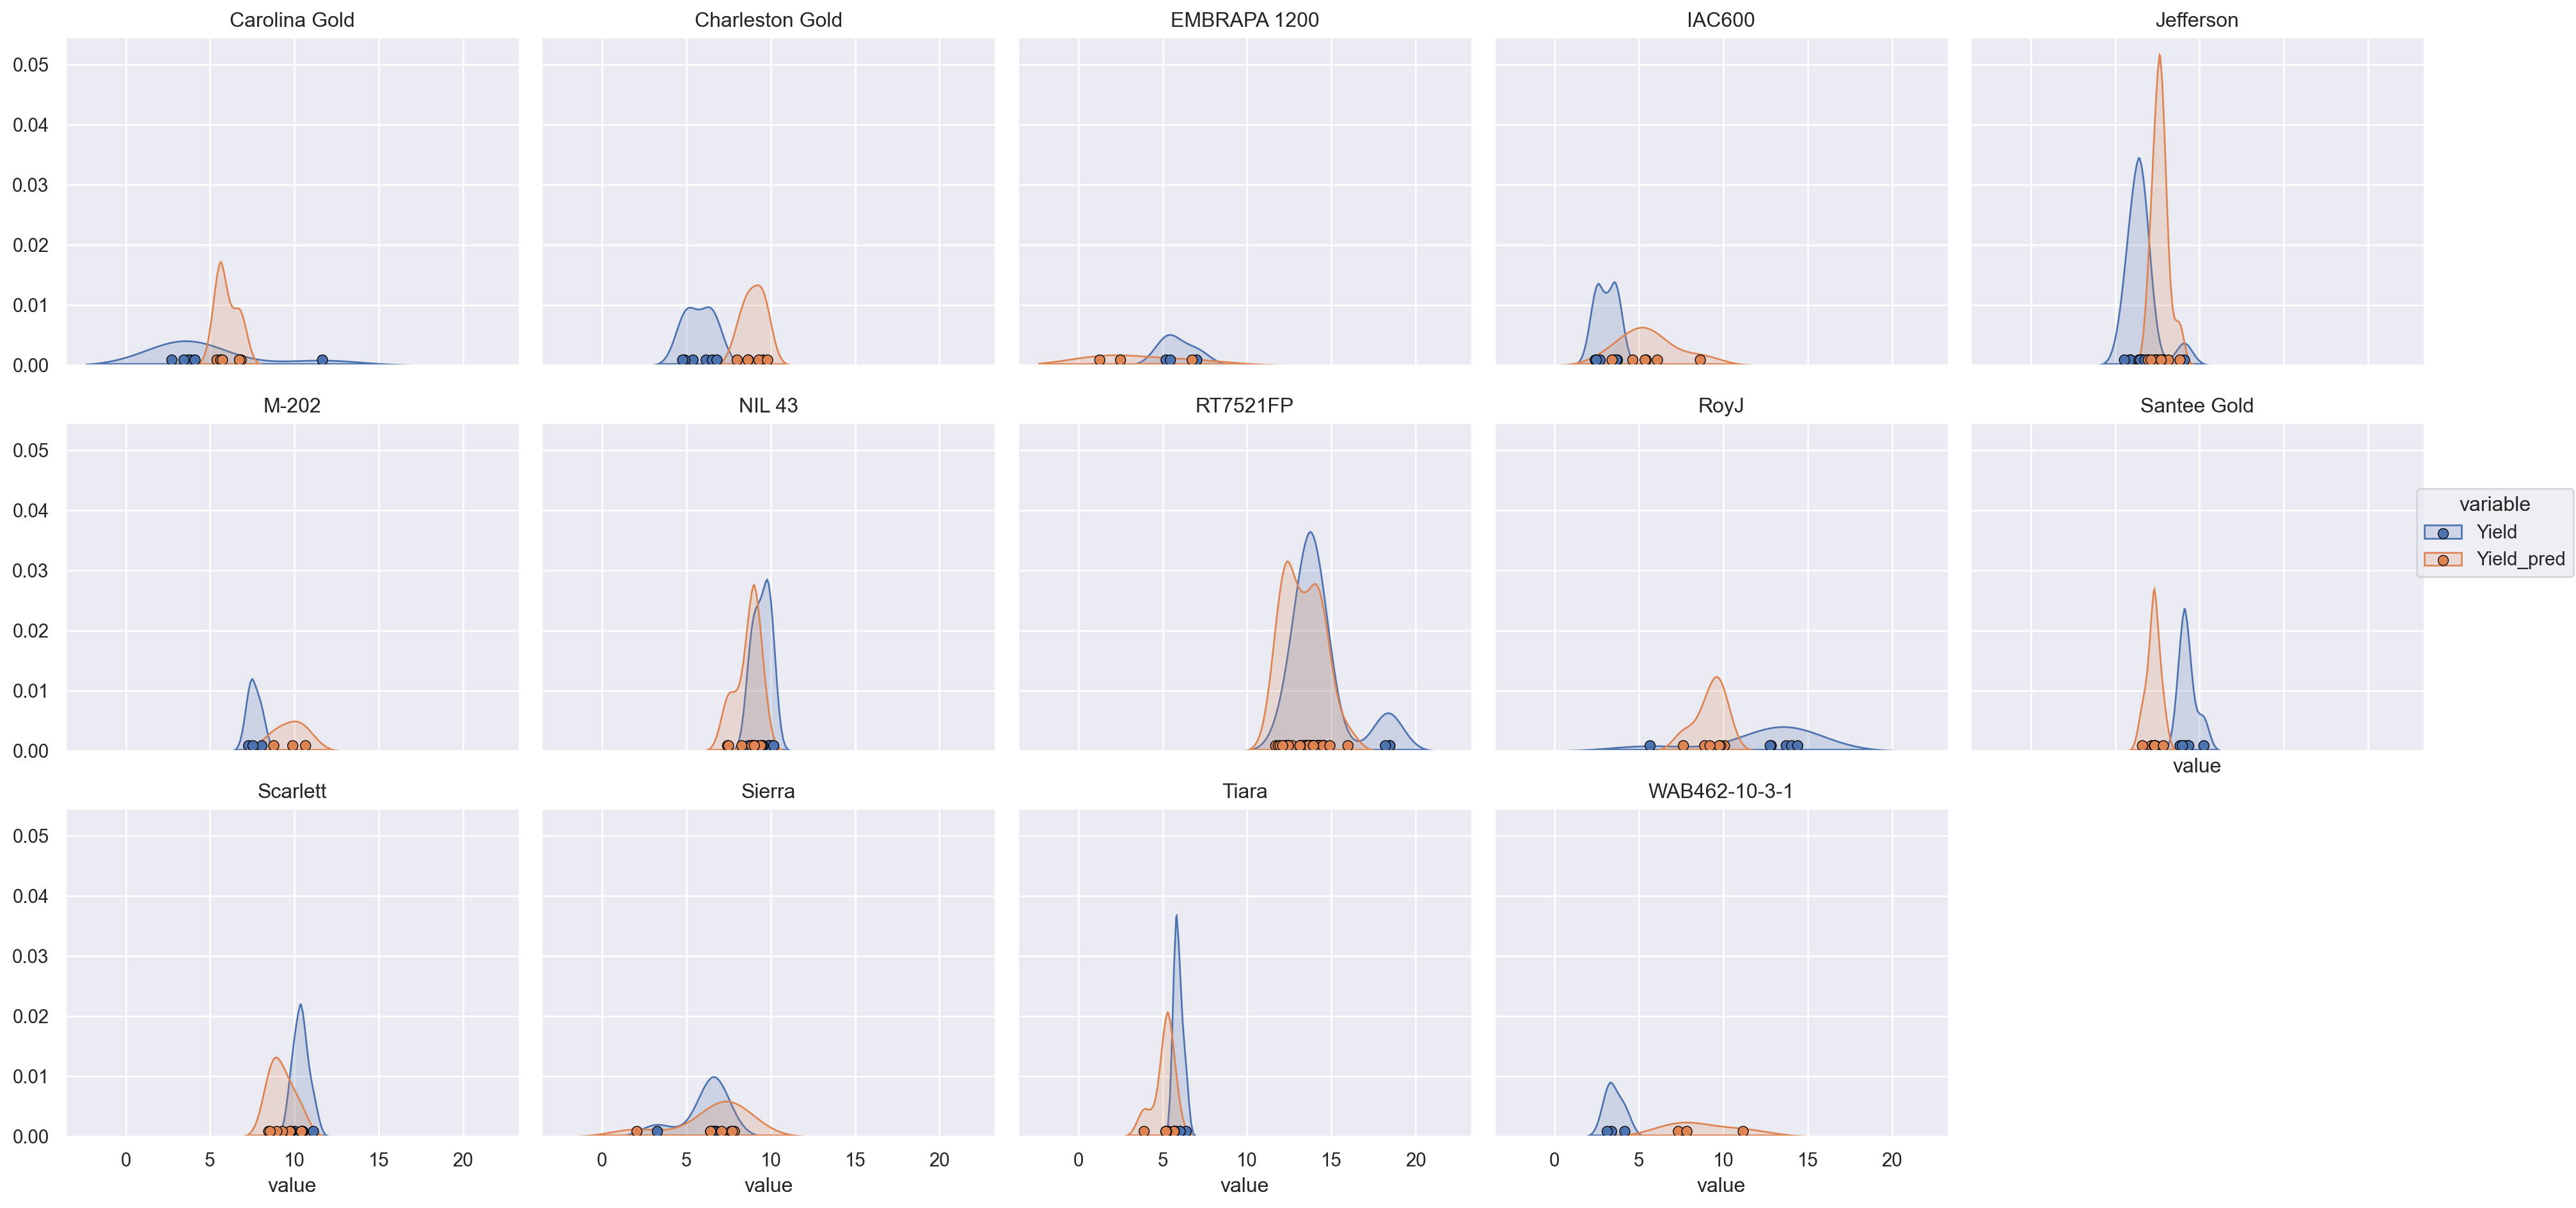

In [22]:
testDf = dfTrain.copy().reset_index(drop=True)
testDf["Yield_pred"] = tunedModel.predict(xTrain)

temp = pd.melt(
    testDf,
    id_vars=testDf.columns[:-3],
    value_vars=["Yield", "Yield_pred"],
)
(
    so.Plot(
        temp,
        x="value",
    )
    .layout(size=(20, 10))
    .facet(
        col="Rice_Cultivar",
        order=sorted(temp["Rice_Cultivar"].unique()),
        wrap=5,
    )
    .add(so.Area(), so.KDE(), color="variable")
    .add(so.Dot(edgecolor="black"), y=[0.0008] * len(temp), color="variable")
)

# del temp, testDf

### Export Model


In [ ]:
# save tuned model
joblib.dump(tunedModel, "Saved_Models/H2A3M1")